In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import windrose as wr

In [3]:
import sys
# # local
# sys.path.append('/Users/rthedin/eagle/a2e-mmc')
# sys.path.append('/Users/temp/')
# Eagle
#sys.path.append('/home/rthedin/a2e-mmc')
from mmctools.plotting import plot_profile

In [4]:
plt.rcParams.update({'font.size': 12})

In [5]:
figdir = './figures'

# WIND Toolkit analysis: data analysis and post-processing
Regis Thedin (regis.thedin@nrel.gov)

This notebook uses processed data from `1-process_raw_data.ipynb`, `2-calculate_QOIs.ipynb`, and `3-characterize_conitions.ipynb`. \
March 2020


In [6]:
zhub = 80    # hub height of TOTW is 80m
g=9.81
Cp = 1004

## 1. Load data

In [7]:
output_dir = 'data'           # path to data output from initial processing notebook
fig_dir = 'fig'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
    
tsdata = 'WTK_ts.calc.csv.gz'    # time-series data
columndata = 'WTK.calc.csv.gz'   # time-height data

In [8]:
dfts = pd.read_csv(os.path.join(output_dir,tsdata),parse_dates=['datetime'],index_col=0)

dfcd_date = pd.read_csv(os.path.join(output_dir,columndata),parse_dates=['datetime'])
dfcd = dfcd_date.set_index(['datetime','height'])

In [9]:
height = dfcd.index.get_level_values('height')
fulldate = dfcd.index.get_level_values('datetime')

month = fulldate.month
timeOfDay = fulldate.hour

In [10]:
seasonaldata = {
    'spring': dfcd.loc[(month >= 3) & (month <= 5),:],
    'summer': dfcd.loc[(month >= 6) & (month <= 8),:],
    'fall':   dfcd.loc[(month >= 9) & (month <= 11),:],
    'winter': dfcd.loc[(month == 12) | (month <= 2),:],
}

monthlydata = {
    'jan': dfcd.loc[(month == 1)],
    'feb': dfcd.loc[(month == 2)],
    'mar': dfcd.loc[(month == 3)],
    'apr': dfcd.loc[(month == 4)],
    'may': dfcd.loc[(month == 5)],
    'jun': dfcd.loc[(month == 6)],
    'jul': dfcd.loc[(month == 7)],
    'aug': dfcd.loc[(month == 8)],
    'sep': dfcd.loc[(month == 9)],
    'oct': dfcd.loc[(month == 10)],
    'nov': dfcd.loc[(month == 11)],
    'dec': dfcd.loc[(month == 12)],
}

hourlydata = {
    '0'  : dfcd.loc[ (timeOfDay >= 0) & (timeOfDay< 1),  :],
    '1'  : dfcd.loc[ (timeOfDay >= 1) & (timeOfDay< 2),  :],
    '2'  : dfcd.loc[ (timeOfDay >= 2) & (timeOfDay< 3),  :],
    '3'  : dfcd.loc[ (timeOfDay >= 3) & (timeOfDay< 4),  :],
    '4'  : dfcd.loc[ (timeOfDay >= 4) & (timeOfDay< 5),  :],
    '5'  : dfcd.loc[ (timeOfDay >= 5) & (timeOfDay< 6),  :],
    '6'  : dfcd.loc[ (timeOfDay >= 6) & (timeOfDay< 7),  :],
    '7'  : dfcd.loc[ (timeOfDay >= 7) & (timeOfDay< 8),  :],
    '8'  : dfcd.loc[ (timeOfDay >= 8) & (timeOfDay< 9),  :],
    '9'  : dfcd.loc[ (timeOfDay >= 9) & (timeOfDay< 10), :],
    '10' : dfcd.loc[ (timeOfDay >= 10) & (timeOfDay<11), :],
    '11' : dfcd.loc[ (timeOfDay >= 11) & (timeOfDay<12), :],
    '12' : dfcd.loc[ (timeOfDay >= 12) & (timeOfDay<13), :],
    '13' : dfcd.loc[ (timeOfDay >= 13) & (timeOfDay<14), :],
    '14' : dfcd.loc[ (timeOfDay >= 14) & (timeOfDay<15), :],
    '15' : dfcd.loc[ (timeOfDay >= 15) & (timeOfDay<16), :],
    '16' : dfcd.loc[ (timeOfDay >= 16) & (timeOfDay<17), :],
    '17' : dfcd.loc[ (timeOfDay >= 17) & (timeOfDay<18), :],
    '18' : dfcd.loc[ (timeOfDay >= 18) & (timeOfDay<19), :],
    '19' : dfcd.loc[ (timeOfDay >= 19) & (timeOfDay<20), :],
    '20' : dfcd.loc[ (timeOfDay >= 20) & (timeOfDay<21), :],
    '21' : dfcd.loc[ (timeOfDay >= 21) & (timeOfDay<22), :],
    '22' : dfcd.loc[ (timeOfDay >= 22) & (timeOfDay<23), :],
    '23' : dfcd.loc[ (timeOfDay >= 23),  :],
}

## 2. Classify stability
From `3-characterize_conditions.ipynb`. Classification based on $L^{-1}$.

In [11]:
Lranges = np.array([-1,-50, -200, -500, 500, 200, 50, 1])
zL_ranges = 2.0 / Lranges
zL_range_names = ['VU','U','NU','N','NS','S','VS']

inrange = (dfts['z/L'] >= zL_ranges[0]) & (dfts['z/L'] <= zL_ranges[-1])
Noutliers = np.count_nonzero(~inrange)
print('{:d} outliers out of {:d} ({:g}%)'.format(Noutliers, len(dfts), 100*Noutliers/len(dfts)))

0 outliers out of 26304 (0%)


In [12]:
dfts['stability_zL'] = pd.cut(dfts['z/L'], bins=zL_ranges, labels=zL_range_names)
zL_ranges

array([-2.   , -0.04 , -0.01 , -0.004,  0.004,  0.01 ,  0.04 ,  2.   ])

## 3. Stability by the hour
Following plots from `3-characterize_conditions.ipynb`, looking at every 1-hour intervals.

In [14]:
zref=2 # for plotting

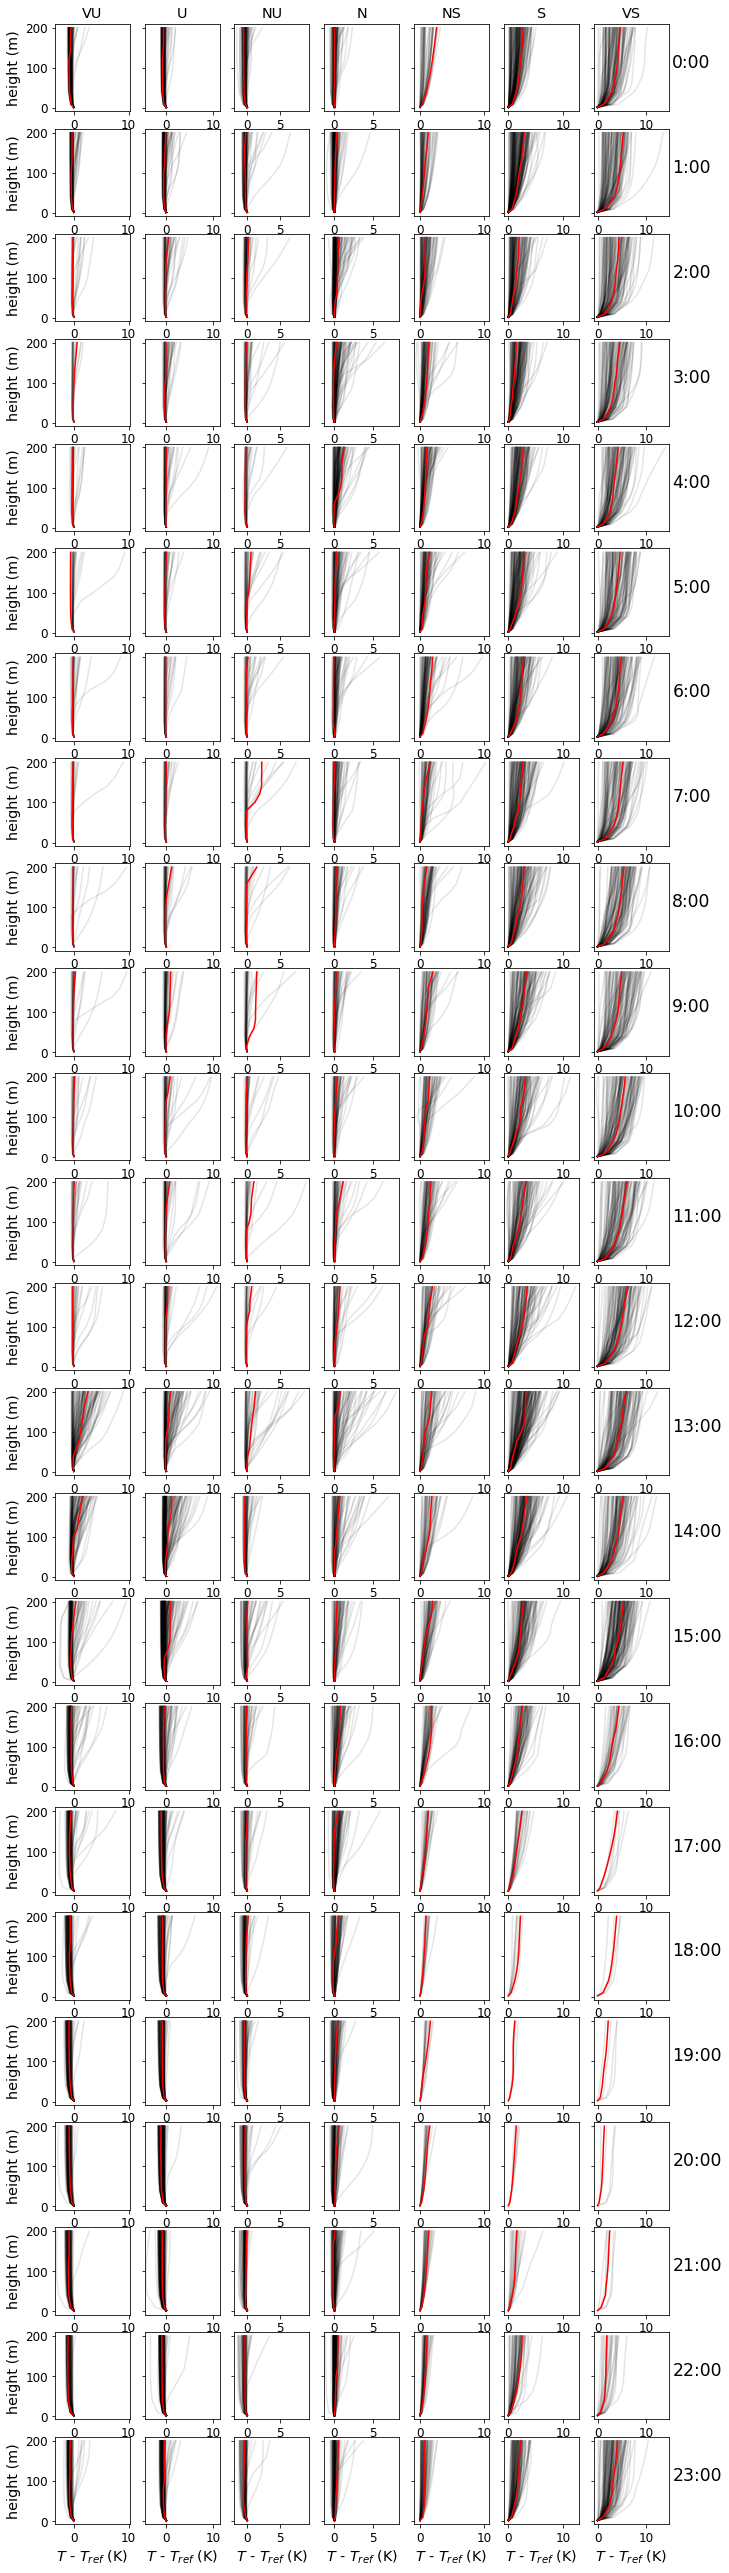

In [15]:
# Potential temperature plots
fig,ax = plt.subplots(nrows=24,ncols=7,sharey=True,figsize=(11,46))
Nplot = 100 # approx num of profiles to plot per panel

for irow,(hour,data) in enumerate(hourlydata.items()):
    dates=data.index.levels[0]
    for icol,stab in enumerate(zL_range_names):
        temp = data.unstack().loc[dfts['stability_zL']==stab,:]
        median = temp['thetav'].median(axis=0)
        median -= median.loc[zref]
        N = len(temp)
        if N>100:
            temp = temp['thetav'].iloc[slice(0,N,int(N/Nplot))]
        else:
            temp = temp['thetav']
        for datetime,profile in temp.iterrows():
            Ttop = profile.loc[zref]
            profile -= Ttop
            ax[irow,icol].plot(profile, profile.index, color='k', alpha=0.1)
        ax[irow,icol].plot(median, median.index, color='r')
    ax[irow,-1].text(1.05, 0.5, f"{hour}:00", fontdict={'fontsize':'x-large'}, transform=ax[irow,-1].transAxes)
    
# make xaxis ranges in each column consistent
for icol in range(len(zL_range_names)):
    allminmax = np.stack([np.array(axi.get_xlim()) for axi in ax[:,icol]])
    minmax = (np.min(allminmax[:,0]), np.max(allminmax[:,1]))
    for axi in ax[:,icol]:
        axi.set_xlim(minmax)
        
# set labels
for axi in ax[-1,:]:
    axi.set_xlabel('$T$ - $T_{ref}$ (K)',fontsize='large')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)',fontsize='large')
for i,axi in enumerate(ax[0,:]):
    axi.set_title(zL_range_names[i])

/home/rthedin/.conda-envs/mynewenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/rthedin/.conda-envs/mynewenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/rthedin/.conda-envs/mynewenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/rthedin/.conda-envs/mynewenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/rthedin/.conda-envs/mynewenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ure

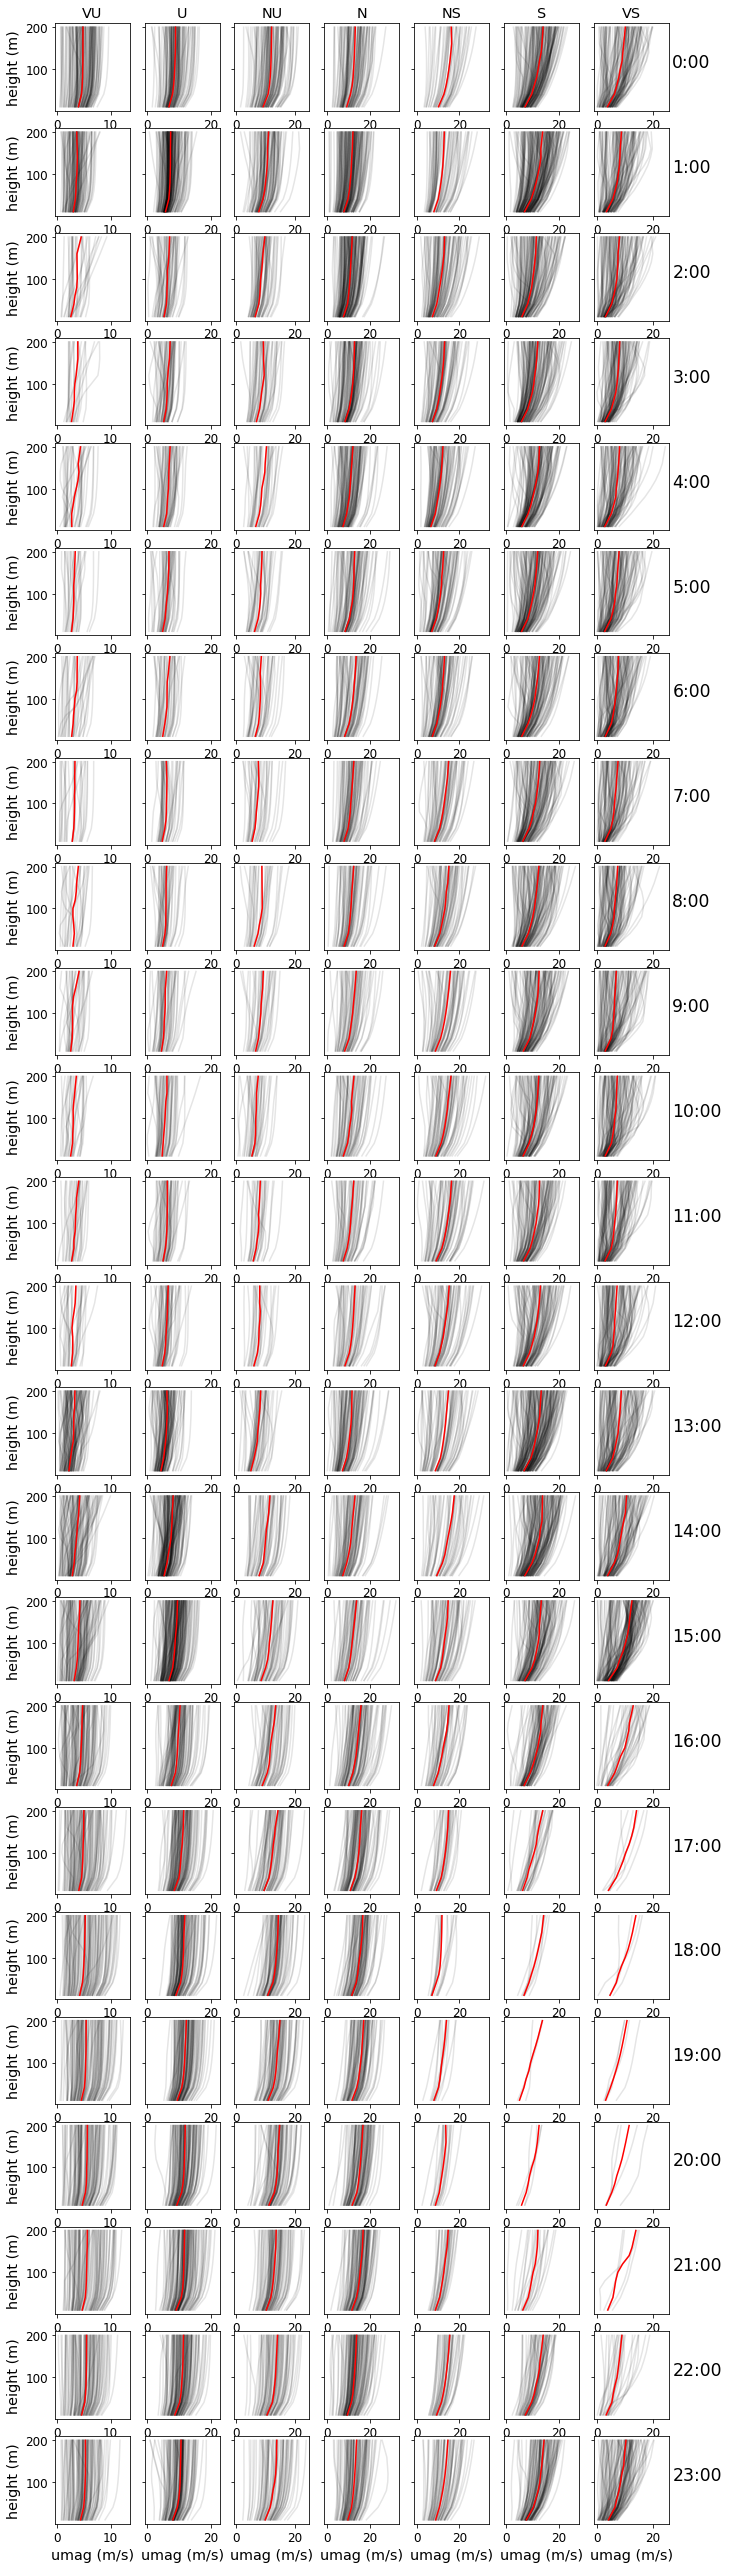

In [16]:
# Wind speed plots
fig,ax = plt.subplots(nrows=24,ncols=7,sharey=True,figsize=(11,46))
Nplot = 100 # approx num of profiles to plot per panel

for irow,(hour,data) in enumerate(hourlydata.items()):
    dates=data.index.levels[0]
    for icol,stab in enumerate(zL_range_names):
        temp = data.unstack().loc[dfts['stability_zL']==stab,:]
        median = temp['windspeed'].median(axis=0)
        N = len(temp)
        if N>100:
            temp = temp['windspeed'].iloc[slice(0,N,int(N/Nplot))]
        else:
            temp = temp['windspeed']
        for datetime,profile in temp.iterrows():
            ax[irow,icol].plot(profile, profile.index, color='k', alpha=0.1)
        ax[irow,icol].plot(median, median.index, color='r')
    ax[irow,-1].text(1.05, 0.5, f"{hour}:00", fontdict={'fontsize':'x-large'}, transform=ax[irow,-1].transAxes)
    
# make xaxis ranges in each column consistent
for icol in range(len(zL_range_names)):
    allminmax = np.stack([np.array(axi.get_xlim()) for axi in ax[:,icol]])
    minmax = (np.min(allminmax[:,0]), np.max(allminmax[:,1]))
    for axi in ax[:,icol]:
        axi.set_xlim(minmax)
        
# set labels
for axi in ax[-1,:]:
    axi.set_xlabel('umag (m/s)',fontsize='large')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)',fontsize='large')
for i,axi in enumerate(ax[0,:]):
    axi.set_title(zL_range_names[i])

## 4. Wind speed by season

In [17]:
# Auxiliary plotting variables
hours_unique = pd.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
heights_unique = pd.array([2,10,40,60,80,100,120,140,160,200])

# Arrays for setting the ticks
hours_ticks =  np.linspace(0,23,24)
heights_ticks = np.array([10,40,60,80,100,120,140,160,200])

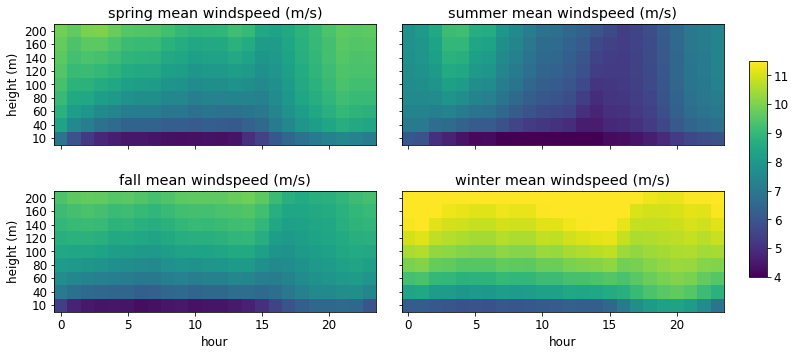

In [18]:
# Wind speed over the seasons, at every height for every hour
fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,6))
fig.subplots_adjust(hspace=0.05, wspace=0.08)
ax=ax1.flatten()

for irow,(season,data) in enumerate(seasonaldata.items()): 
    data = data.assign(hour = data.index.get_level_values('datetime').hour)
    d_ri = data.reset_index()
    height = d_ri['height']
    hour = d_ri['hour']
    ws = np.zeros(shape=(len(heights_unique),len(hours_unique)))
    for (i,z) in enumerate(heights_unique):
        for (j,h) in enumerate(hours_unique):
            d = data.reset_index().loc[(hour==h) & (height==z)]
            ws[i,j] = d['windspeed'].mean()
            
    # skipping first row bc it's empty (height=2)        
    p = ax[irow].imshow(ws[1:,:], origin='lower',vmin=4, vmax=11.5)
    ax[irow].set_title(f"{season} mean windspeed (m/s)")
    
# set labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5])
fig.colorbar(p, cax = cb_ax) 
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.linspace(0,8,9))
    axi.set_yticklabels(heights_ticks)
    

### - Focusing on the heights spanning the rotors

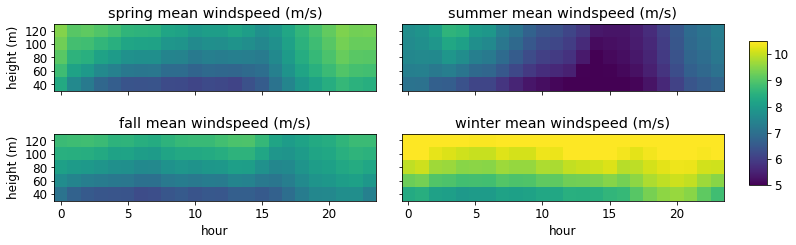

In [19]:
# Wind speed over the seasons, near-turbine heights, for every hour
fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,4))
fig.subplots_adjust(hspace=0.02, wspace=0.08)
ax=ax1.flatten()

for irow,(season,data) in enumerate(seasonaldata.items()): 
    data = data.assign(hour = data.index.get_level_values('datetime').hour)
    d_ri = data.reset_index()
    height = d_ri['height']
    hour = d_ri['hour']
    ws = np.zeros(shape=(len(heights_unique),len(hours_unique)))
    for (i,z) in enumerate(heights_unique):
        for (j,h) in enumerate(hours_unique):
            d = data.reset_index().loc[(hour==h) & (height==z)]
            ws[i,j] = d['windspeed'].mean()
            
    # skipping first row bc it's empty (height=2)        
    p = ax[irow].imshow(ws[2:7,:], origin='lower',vmin=5, vmax=10.5)
    ax[irow].set_title(f"{season} mean windspeed (m/s)")
    
# set labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5])
fig.colorbar(p, cax = cb_ax) 
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.linspace(0,4,5))
    axi.set_yticklabels(np.array([40,60,80,100,120]))
    
fig.savefig(os.path.join(figdir, 'wtk_windpeedbyseason.png'), bbox_inches='tight', dpi=150)

## 5. Daytime and nighttime wind roses
`windrose` convention for wind direction: northerly winds (from N to S) is 0 degrees, increase clockwise


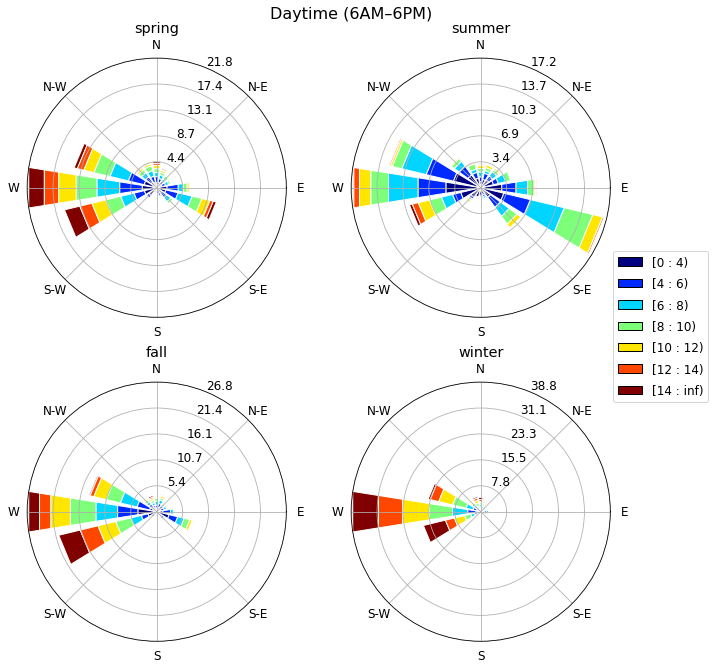

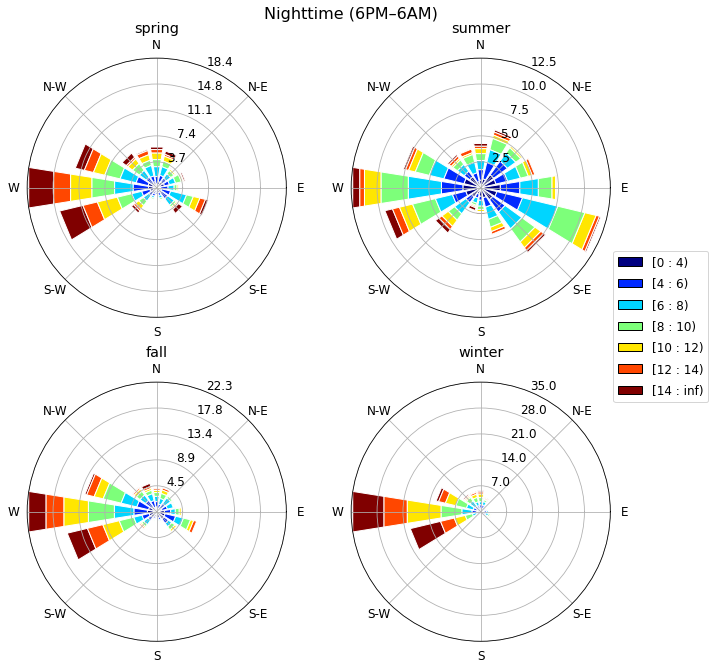

In [20]:
# Daytime
fig = plt.figure(figsize=(9,9))
rec = [[0,0.5,0.4,0.4],[0.5,0.5,0.4,0.4],[0,0,0.4,0.4],[0.5,0,0.4,0.4]]
fig.suptitle('Daytime (6AM–6PM)', fontsize=16)

for irow,(season,data) in enumerate(seasonaldata.items()): 
    data = data.assign(hour = data.index.get_level_values('datetime').hour)
    d_ri = data.reset_index()
    height = d_ri['height']
    hour = d_ri['hour']

    d = data.reset_index().loc[((hour>=6) & (hour<18)) & (height==zhub)]
    ws = d['windspeed'].values
    wd = d['winddirection'].values
    wa = wr.WindroseAxes(fig, rec[irow])
    fig.add_axes(wa)
    wa.bar(wd, ws, normed=True, bins=([0,4,6,8,10,12,14]), opening=0.8, edgecolor='white')
    wa.set_title(f"{season}")

wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(1.4,0.9))
plt.show()  
fig.savefig(os.path.join(figdir, 'wtk_windroseDaytime.png'), bbox_inches='tight', dpi=150)

print("\n\n")

# Nighttime
fig = plt.figure(figsize=(9,9))
fig.suptitle('Nighttime (6PM–6AM)', fontsize=16)

for irow,(season,data) in enumerate(seasonaldata.items()): 
    data = data.assign(hour = data.index.get_level_values('datetime').hour)
    d_ri = data.reset_index()
    height = d_ri['height']
    hour = d_ri['hour']

    d = data.reset_index().loc[((hour>=18) | (hour<6)) & (height==zhub)]
    ws = d['windspeed'].values
    wd = d['winddirection'].values
    wa=wr.WindroseAxes(fig, rec[irow])
    fig.add_axes(wa)
    wa.bar(wd, ws, normed=True, bins=([0,4,6,8,10,12,14]), opening=0.8, edgecolor='white')
    wa.set_title(f"{season}")

wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(1.4,0.9))
plt.show()
fig.savefig(os.path.join(figdir, 'wtk_windroseNighttime.png'), bbox_inches='tight', dpi=150)


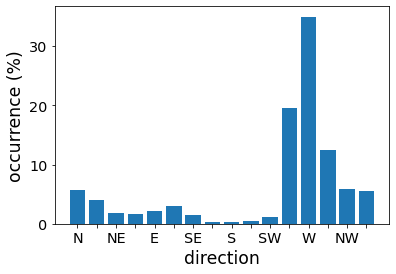

In [21]:
# Some probability distribution plots using the same data (just another way to look at them)
# Only the last one shown (nighttime, winter)

table = wa._info['table']
wd_freq = np.sum(table, axis=0)
direction = wa._info['dir']

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(np.arange(16), wd_freq, align='center')
ax.set_xticks(np.arange(16))
ax.set_xticklabels(['N','','NE','','E','','SE','','S','','SW','','W','','NW',''])
plt.tick_params(labelsize='large')
plt.xlabel('direction',fontsize='x-large')
plt.ylabel('occurrence (%)',fontsize='x-large')
plt.show()

## - Wind speed and heat flux distributions on selected scenarios

In [22]:
# Classify winds by Cardinal directions
# (binning the whole dataframe through np.digitize doesn't work well because of the NaN entries)

# Spring
sp=seasonaldata['spring'].reset_index()
sp['hour'] = sp['datetime'].dt.hour
height = sp['height']
hour = sp['hour']
wd = sp['winddirection']
ws = sp['windspeed']

# spNwinds   = sp.loc[((hour>=6) & (hour<18)) & ((wd>348.75) | (wd<=11.25 )) & (height==zhub)]
# spNNEwinds = sp.loc[((hour>=6) & (hour<18)) & ((wd>11.25 ) & (wd<=33.75 )) & (height==zhub)]
# spNEwinds  = sp.loc[((hour>=6) & (hour<18)) & ((wd>33.75 ) & (wd<=56.25 )) & (height==zhub)]
# spENEwinds = sp.loc[((hour>=6) & (hour<18)) & ((wd>56.25 ) & (wd<=78.75 )) & (height==zhub)]
# spEwinds   = sp.loc[((hour>=6) & (hour<18)) & ((wd>78.75 ) & (wd<=101.25)) & (height==zhub)]
spESEwinds = sp.loc[((hour>=6) & (hour<18)) & ((wd>101.25) & (wd<=123.75)) & (height==zhub)]
# spSEwinds  = sp.loc[((hour>=6) & (hour<18)) & ((wd>123.75) & (wd<=146.25)) & (height==zhub)]
# spSSEwinds = sp.loc[((hour>=6) & (hour<18)) & ((wd>146.25) & (wd<=168.75)) & (height==zhub)]
# spSwinds   = sp.loc[((hour>=6) & (hour<18)) & ((wd>168.75) & (wd<=191.25)) & (height==zhub)]
# spSSWwinds = sp.loc[((hour>=6) & (hour<18)) & ((wd>191.25) & (wd<=213.75)) & (height==zhub)]
# spSWwinds  = sp.loc[((hour>=6) & (hour<18)) & ((wd>213.75) & (wd<=236.25)) & (height==zhub)]
# spWSWwinds = sp.loc[((hour>=6) & (hour<18)) & ((wd>236.25) & (wd<=258.75)) & (height==zhub)]
spWwinds   = sp.loc[((hour>=6) & (hour<18)) & ((wd>258.75) & (wd<=281.25)) & (height==zhub)]
# spWNWwinds = sp.loc[((hour>=6) & (hour<18)) & ((wd>281.25) & (wd<=303.75)) & (height==zhub)]
# spNWwinds  = sp.loc[((hour>=6) & (hour<18)) & ((wd>303.75) & (wd<=326.25)) & (height==zhub)]
# spNNWwinds = sp.loc[((hour>=6) & (hour<18)) & ((wd>326.25) & (wd<=348.75)) & (height==zhub)]


# Summer
su=seasonaldata['summer'].reset_index()
su['hour'] = su['datetime'].dt.hour
height = su['height']
hour = su['hour']
wd = su['winddirection']
ws = su['windspeed']

suWwinds   = su.loc[((hour>=6) & (hour<18)) & ((wd>258.75) & (wd<=281.25)) & (height==zhub)]
suESEwinds = su.loc[((hour>=6) & (hour<18)) & ((wd>101.25) & (wd<=123.75)) & (height==zhub)]

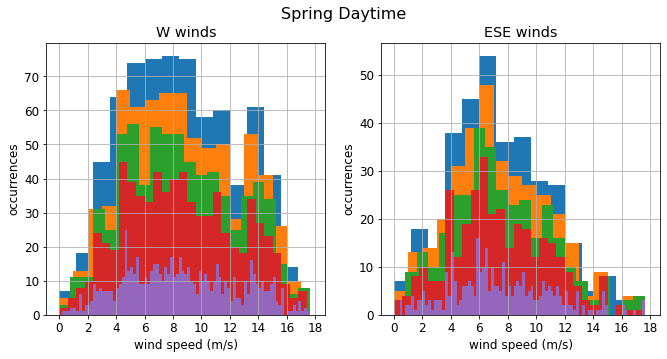

In [23]:
# Spring, daytime

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(11,5))

spWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,1.2))
spESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,1.2))
spWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,1))
spESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,1))
spWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,0.8))
spESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,0.8))
spWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,0.6))
spESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,0.6))
spWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,0.2))
spESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,0.2))

for ax in axes:
    ax.set_xlabel('wind speed (m/s)')
    ax.set_ylabel('occurrences')
    ax.set_xticks(np.arange(0,19,2))
    
axes[0].set_title('W winds')
axes[1].set_title('ESE winds')

fig.suptitle('Spring Daytime', fontsize=16)
plt.show()

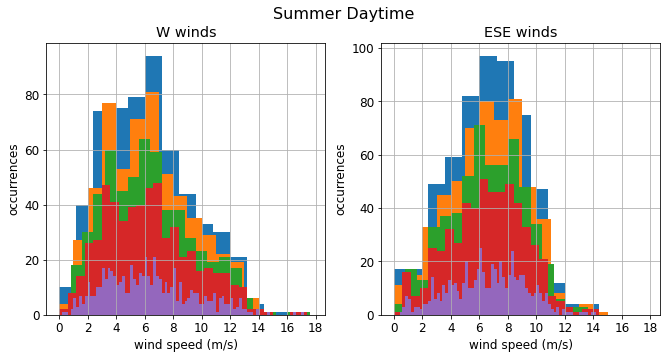

In [24]:
# Summer, daytime

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(11,5))

suWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,1.2))
suESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,1.2))
suWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,1))
suESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,1))
suWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,0.8))
suESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,0.8))
suWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,0.6))
suESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,0.6))
suWwinds['windspeed'].hist(ax=axes[0],   bins=np.arange(0,18,0.2))
suESEwinds['windspeed'].hist(ax=axes[1], bins=np.arange(0,18,0.2))

for ax in axes:
    ax.set_xlabel('wind speed (m/s)')
    ax.set_ylabel('occurrences')
    ax.set_xticks(np.arange(0,19,2))
    
axes[0].set_title('W winds')
axes[1].set_title('ESE winds')

fig.suptitle('Summer Daytime', fontsize=16)
plt.show()

### Get typical heat flux

In [25]:
# Using the heat flux that comes from WRF heat (W/m^2). See notebook 2-calculate_QOI for a discussion
# on different methods of calculating it

In [26]:
dfts['hfx_Kmps']=  dfts['hfx']/(Cp*dfcd['density'].xs(2.0,level='height'))
tsri = dfts.reset_index()

In [27]:
UandVU = tsri.loc[(tsri['stability_zL']=='U') | (tsri['stability_zL']=='VU')]

spESEwinds_hfx = pd.merge(spESEwinds,UandVU, on='datetime',how='inner')
spWwinds_hfx = pd.merge(spWwinds,UandVU, on='datetime',how='inner')
suESEwinds_hfx = pd.merge(suESEwinds,UandVU, on='datetime',how='inner')
suWwinds_hfx = pd.merge(suWwinds,UandVU, on='datetime',how='inner')

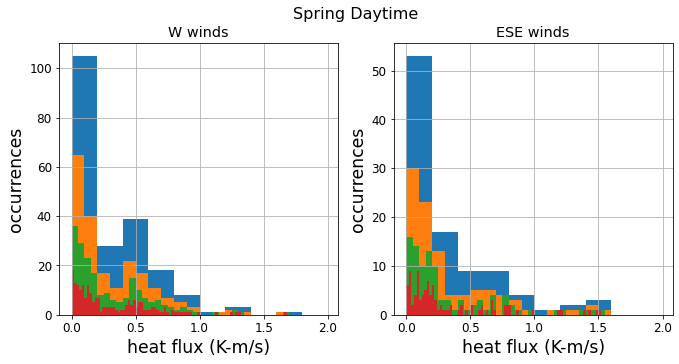

In [28]:
# Spring, daytime, only U and VU cases

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(11,5))

spWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.2))
spESEwinds_hfx['hfx_Kmps'].hist(ax=axes[1], bins=np.arange(0,2,0.2))
spWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.1))
spESEwinds_hfx['hfx_Kmps'].hist(ax=axes[1], bins=np.arange(0,2,0.1))
spWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.05))
spESEwinds_hfx['hfx_Kmps'].hist(ax=axes[1], bins=np.arange(0,2,0.05))
spWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.02))
spESEwinds_hfx['hfx_Kmps'].hist(ax=axes[1], bins=np.arange(0,2,0.02))

for ax in axes:
    ax.set_xlabel(r'heat flux (K-m/s)',fontsize='x-large')
    ax.set_ylabel(r'occurrences',fontsize='x-large')
    #ax.set_xticks(np.arange(0,19,2))
    
axes[0].set_title('W winds')
axes[1].set_title('ESE winds')

fig.suptitle('Spring Daytime', fontsize=16)
plt.show()

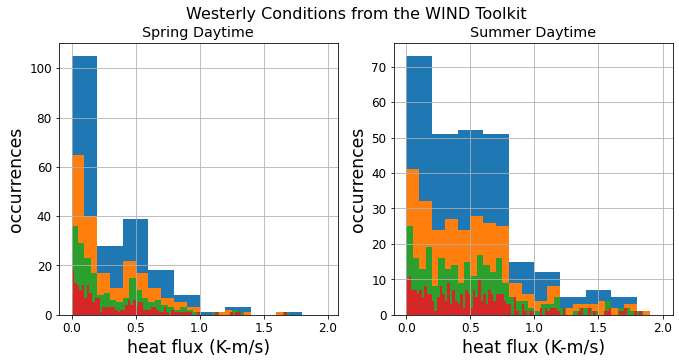

In [29]:
# Spring and summer daytime, only U and VU cases

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(11,5))

spWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.2))
suWwinds_hfx['hfx_Kmps'].hist(ax=axes[1],   bins=np.arange(0,2,0.2))
spWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.1))
suWwinds_hfx['hfx_Kmps'].hist(ax=axes[1],   bins=np.arange(0,2,0.1))
spWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.05))
suWwinds_hfx['hfx_Kmps'].hist(ax=axes[1],   bins=np.arange(0,2,0.05))
spWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.02))
suWwinds_hfx['hfx_Kmps'].hist(ax=axes[1],   bins=np.arange(0,2,0.02))

for ax in axes:
    ax.set_xlabel(r'heat flux (K-m/s)',fontsize='x-large')
    ax.set_ylabel(r'occurrences',fontsize='x-large')
    #ax.set_xticks(np.arange(0,19,2))
    
axes[0].set_title('Spring Daytime')
axes[1].set_title('Summer Daytime')

fig.suptitle('Westerly Conditions from the WIND Toolkit', fontsize=16)
plt.show()
fig.savefig(os.path.join(figdir, 'wtk_heatflux.png'), bbox_inches='tight', dpi=150)

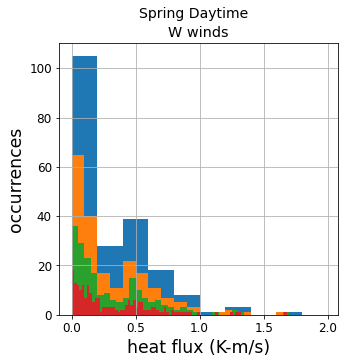

In [30]:
# Spring, daytime, only U and VU cases

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

spWwinds_hfx['hfx_Kmps'].hist(ax=ax,   bins=np.arange(0,2,0.2))
spWwinds_hfx['hfx_Kmps'].hist(ax=ax,   bins=np.arange(0,2,0.1))
spWwinds_hfx['hfx_Kmps'].hist(ax=ax,   bins=np.arange(0,2,0.05))
spWwinds_hfx['hfx_Kmps'].hist(ax=ax,   bins=np.arange(0,2,0.02))


ax.set_xlabel(r'heat flux (K-m/s)',fontsize='x-large')
ax.set_ylabel(r'occurrences',fontsize='x-large')
#ax.set_xticks(np.arange(0,19,2))
    
ax.set_title('W winds')


fig.suptitle('Spring Daytime', fontsize=14)
plt.show()
fig.savefig(os.path.join(figdir, 'wtk_heatflueSpring.png'), bbox_inches='tight', dpi=150)

It looks like there is a peak at around 0.5 W-m/s for W winds, but this value seems too high. For W winds, selecting 0.15 W-m/s; and for ESE winds, 0.2 W-m/s.



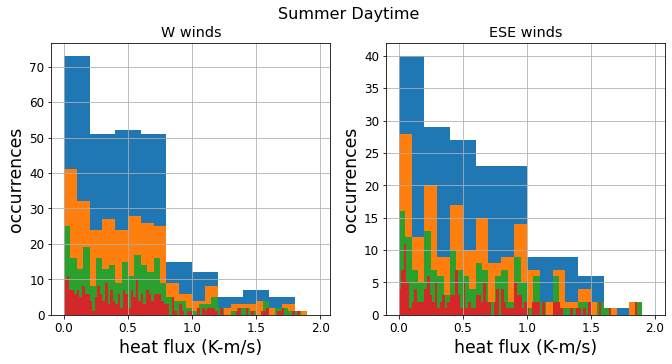

In [31]:
# Summer, daytime, only U and VU cases

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(11,5))

suWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.2))
suESEwinds_hfx['hfx_Kmps'].hist(ax=axes[1], bins=np.arange(0,2,0.2))
suWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.1))
suESEwinds_hfx['hfx_Kmps'].hist(ax=axes[1], bins=np.arange(0,2,0.1))
suWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.05))
suESEwinds_hfx['hfx_Kmps'].hist(ax=axes[1], bins=np.arange(0,2,0.05))
suWwinds_hfx['hfx_Kmps'].hist(ax=axes[0],   bins=np.arange(0,2,0.02))
suESEwinds_hfx['hfx_Kmps'].hist(ax=axes[1], bins=np.arange(0,2,0.02))

for ax in axes:
    ax.set_xlabel(r'heat flux (K-m/s)',fontsize='x-large')
    ax.set_ylabel(r'occurrences',fontsize='x-large')
    #ax.set_xticks(np.arange(0,19,2))
    
axes[0].set_title('W winds')
axes[1].set_title('ESE winds')

fig.suptitle('Summer Daytime', fontsize=16)
plt.show()

There is no clear peak. Values seem too high as well. Nonetheless this is summer time so selecting values higher than spring time. For W winds, selecting 0.5 W-m/s; and for ESE winds, 0.25 W-m/s

### Selected scenarios

Based on the histogram plots above, the following conditions have been identified and executed:

Neutral cases:

| Scenario                | Wind dir    | Wind speed | $z_0$  | $\Delta T$ inv (K) | heat flux (K-m/s) |
|------------------------:|:-----------:|:----------:|:------:|:------------------:|:-----------------:|
| Spring daytime neutral  | W  270deg   | 5 m/s      | 0.05 m | 5K                 |        0          |
| Spring daytime neutral  | W  270deg   | 14 m/s     | 0.05 m | 10K                |        0          |
| Spring daytime neutral  | ESE 112.5deg| 14 m/s     | 0.05 m | 5K                 |        0          |
| Summer daytime neutral  | W  270deg   | 6 m/s      | 0.06 m | 5K                 |        0          |
| Summer daytime neutral  | ESE 112.5deg| 7 m/s      | 0.06 m | 5K                 |        0          |


Convective cases:

| Scenario                 | Wind dir    | Wind speed | $z_0$  | $\Delta T$ inv (K) | heat flux (K-m/s) |
|-------------------------:|:-----------:|:----------:|:------:|:------------------:|:-----------------:|
| Spring daytime unstable  | W  270deg   | 5 m/s      | 0.05 m | 8K                 |           0.15    |
| Spring daytime unstable  | W  270deg   | 14 m/s     | 0.05 m | 16K                |           0.15    |
| Spring daytime unstable  | ESE 112.5deg| 14 m/s     | 0.05 m | 16K                |           0.2     |
| Summer daytime unstable  | W  270deg   | 6 m/s      | 0.06 m | 8K                 |           0.5     |
| Summer daytime unstable  | ESE 112.5deg| 7 m/s      | 0.06 m | 8K                 |           0.25    |

## 6. Thermal updrafts
Attempting to classify by thermal updrafts. The convective velocity for CBLs $w_*$ is given by
\begin{equation}
w_* = \left( \frac{g z_i \overline{(\theta'w')}_s}{\bar{\theta}} \right)^{1/3} 
\end{equation}

Greenhut and Khalsa (J. Clim. Appl. Meteorol., 1982) defined thermal updrafts and downdrafts as those parts of the data series that exceed a specific velocity threshold. Thermal updrafts are defined as that part of the data series in which the vertical velocity exceeds $0.56w_∗$, and thermal downdrafts are defined as that part of the data series in which the vertical velocity is less than $−0.40w_∗$.

The WIND toolkit dataset does not give individual components of the velocity.

There is no way to accurately compute the convetive velocity from the data the WIND toolkit provides. This section is just an exercise and sanity-check of ball-park numbers.

### - Fixing the boundary layer height
WIND data only goes up to 200m.

In [32]:
z_i = 200

In [33]:
ts=dfts
cd=dfcd

### - Estimate the convective velocity

In [34]:
U_at_z = cd['windspeed'].xs(40,level='height')

# Reverting the surface heat flux to Km/s from the saved W/m^2
Tw = ts['hfx']/(Cp*cd['density'].xs(2.0,level='height'))

z=200
T_at_z = cd['thetav'].xs(z,level='height')

ts['w*'] = (g*z_i*Tw/T_at_z)**(1/3)

In [35]:
# Across all stability states
print(ts['w*'].describe())

count    12173.000000
mean         1.069103
std          0.552466
min          0.000000
25%          0.644193
50%          1.001723
75%          1.526832
max          2.797746
Name: w*, dtype: float64


count    3237.000000
mean        0.943007
std         0.377745
min         0.035048
25%         0.668635
50%         0.890785
75%         1.192785
max         1.943672
Name: w*, dtype: float64


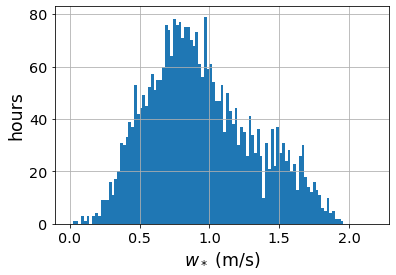

In [36]:
# Get the unstable scenarios only
temp = ts.loc[ts['stability_zL']=='U']
print(temp['w*'].describe())

ax = temp['w*'].hist(bins=np.arange(0,2.2,0.02))
plt.tick_params(labelsize='large')
plt.xlabel(r'$w_*$ (m/s)',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')
plt.show()

### - Estimate the mean vertical velocity in thermal updrafts
Using
\begin{equation}
\frac{\overline{w_T}}{w_*} = 0.85 \left( \frac{z}{z_i} \right)^{1/3} \left( 1.3 - \frac{z}{z_i} \right)
\end{equation}

from Shannon et al, BLM 104: 167--199, "Measurements of Thermal Updraft Intensity Over Complex Terrain Using American White Pelicans and a Simple Boundary-Layer Forecast Model".

Again, not actually valid since $w_*$ is not accurate.

In [37]:
cd_ri = cd.reset_index()
z = cd.reset_index()['height'].values

wstar = ts['w*'].repeat(len(heights_unique)).values

In [38]:

cd['wT'] = wstar*0.85*(z/z_i)**(1/3)*(1.3-z/z_i)

In [39]:
# Across all stability states
print(cd['wT'].describe())

count    121730.000000
mean          0.475864
std           0.283429
min           0.000000
25%           0.258493
50%           0.425034
75%           0.665985
max           1.591968
Name: wT, dtype: float64


count    32370.000000
mean         0.419737
std          0.205958
min          0.008279
25%          0.261129
50%          0.387570
75%          0.544716
max          1.105984
Name: wT, dtype: float64


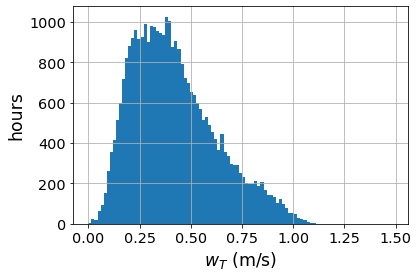

In [40]:
# Get the unstable scenarios only
stab = ts['stability_zL'].repeat(len(heights_unique)).values

temp = cd.loc[stab=='U']
print(temp['wT'].describe())

ax = temp['wT'].hist(bins=np.arange(0,1.5,0.015))
plt.tick_params(labelsize='large')
plt.xlabel(r'$w_T$ (m/s)',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')
plt.show()